# Large Growth Fund Prediction Modelling: Random Forest Classifier
This section uses a Random Forest Classifier model to predict the probable direction of prices for the top 4 Large Growth ETFs ('High Risk / High Reward') by fund size (in billions - USD). As mentioned on Notebook 3, those index funds are:<br />

QQQ - Invesco QQQ Trust<br />
VUG - Vanguard Growth Index Fund<br />
IWF - iShares Russell 1000 Growth ETF<br />
IVW - iShares S&P 500 Growth ETF<br />

<br />
The notebook's sections about the Prediction / Machine Learning Model are:<br />
1. Set up libraries, download historical data & visualize data<br />
2. Set up Machine Learning / M.L. target<br />
3. Train our initial model (Random Forest Classifier)<br />
4. Build a backtest system<br />
5. See results from backtest system (2nd round of predictions)<br />
6. Insert extra prediction ratio columns<br />
7. Run predictions (3rd round) using backtest again<br />
8. after adding ratios & modifying prediction function<br />
9. Statistical results - IMPORTANT<br />
10. Conclusion - IMPORTANT<br />

<br />
Morningstar fund definitions:<br /> 
1. Large Growth Funds are defined as those that invest in large-sized companies projected to grow fast. These tend to have high volatility, and high valuations (high price ratios & low dividend yields). These are known for being ‘high risk but high reward’.<br />
2. Large Value Funds are defined as those that invest in large-sized companies that have slow growth and low valuations (low price ratios and high dividend yields).<br />
3. Large Blend Funds are defined as those that invest in a combination of large Value & large Growth. These funds represent the overall U.S. Stock market and invest in across the spectrum of U.S. industries.<br />

# What is a Random Forest?

Random forests or random decision forests is a learning method for classification, regression and other tasks that operates by constructing a multitude of decision trees at training time. For classification tasks, the output of the random forest is the class selected by most trees - therefore the output of multiple decision trees reach a single result. Random decision forests correct for decision trees' habit of overfitting to their training set. In this case, the outcome is the probability that states how likely is for prices to increase tomorrow.

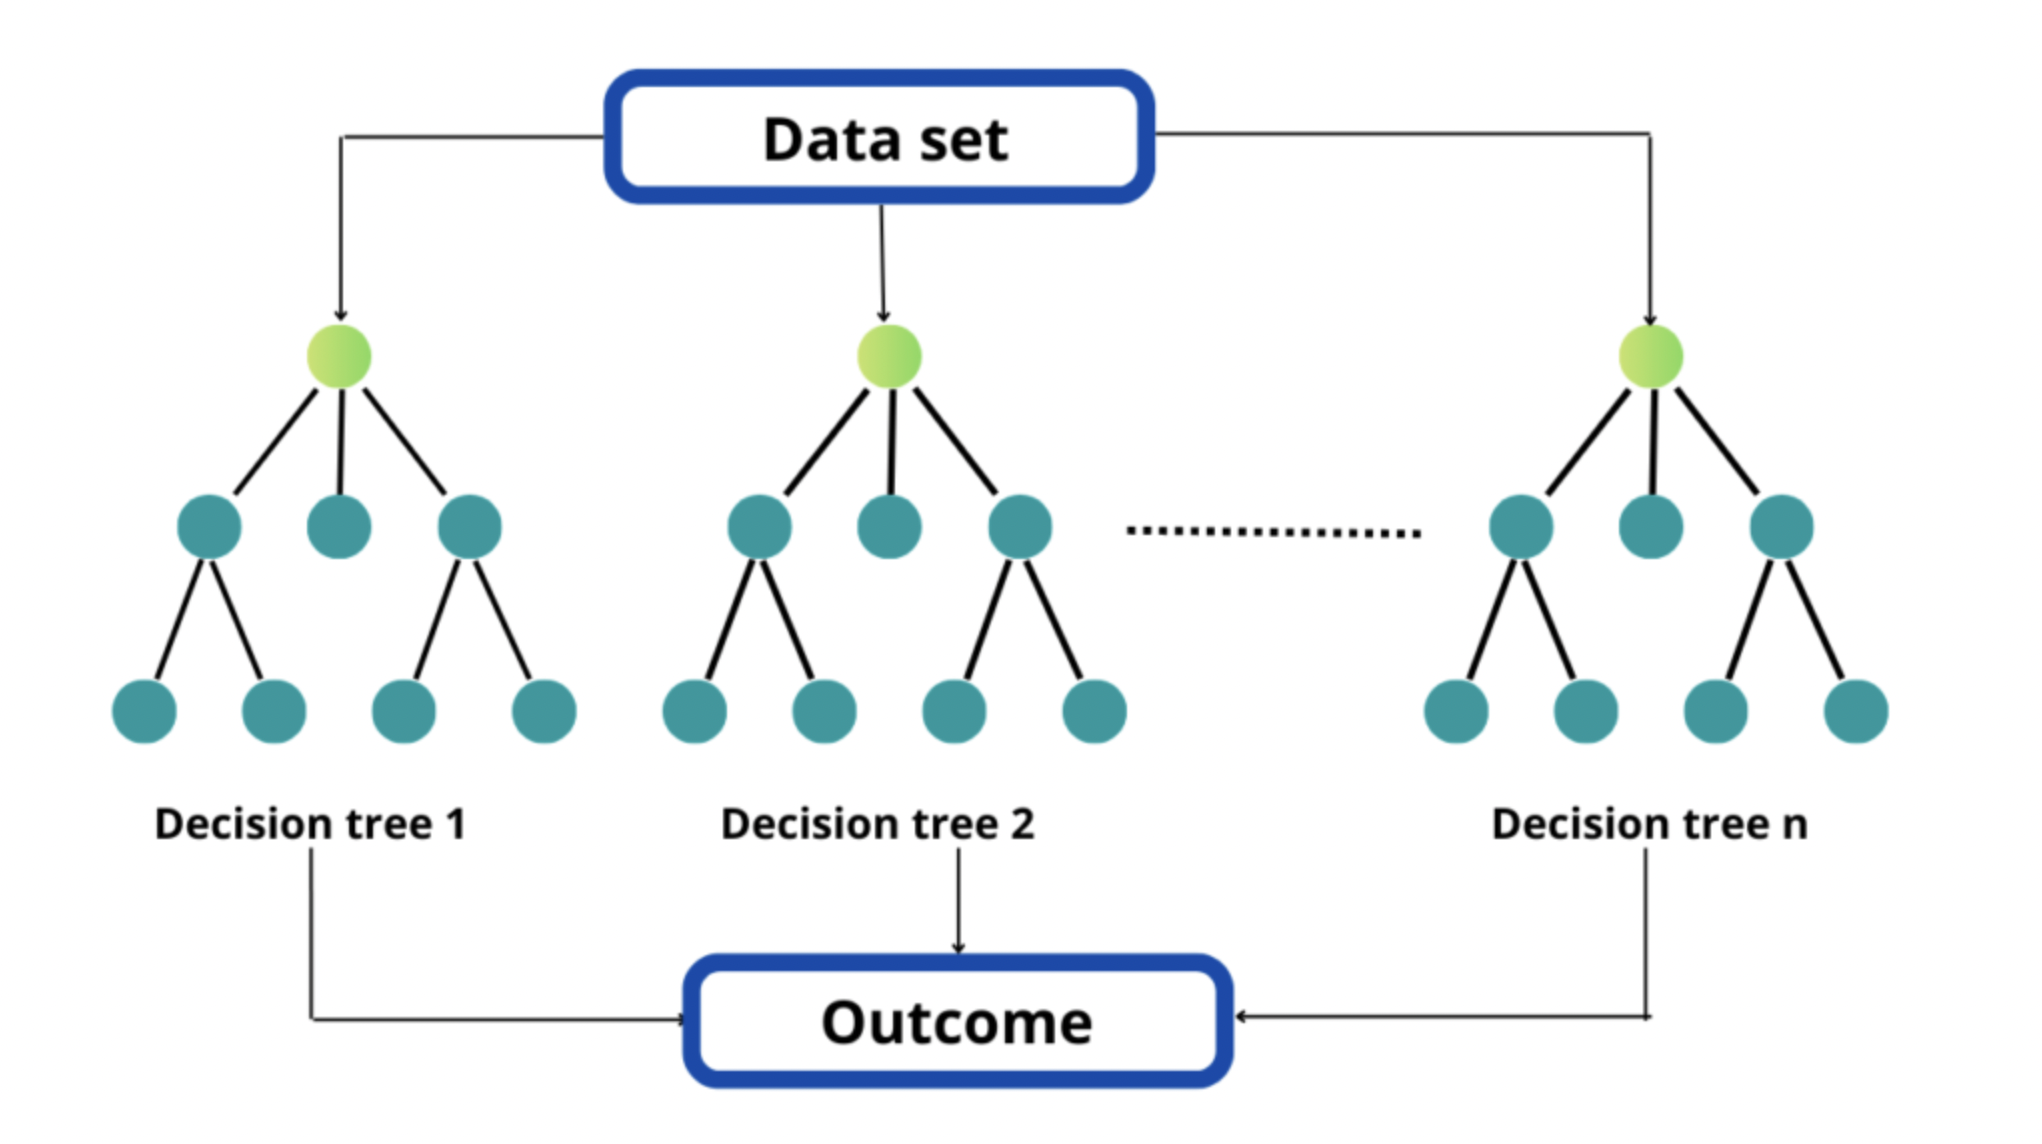

# Step 1 - Import libraries, download historical data & visualize data

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import yfinance as yf

# Machine Learning Libraries
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import precision_score

In [2]:
# Get data; starting dates are the funds' inception dates
qqq = yf.download("QQQ", '1999-03-10', '2023-12-30')
vug = yf.download("VUG", '2004-01-26', '2023-12-30')
iwf = yf.download("IWF", '2000-05-22', '2023-12-30')
ivw = yf.download("IVW", '2000-05-22', '2023-12-30')

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


In [3]:
# Check index
qqq.index
#vug.index
#iwf.index
#ivw.index

DatetimeIndex(['1999-03-10', '1999-03-11', '1999-03-12', '1999-03-15',
               '1999-03-16', '1999-03-17', '1999-03-18', '1999-03-19',
               '1999-03-22', '1999-03-23',
               ...
               '2023-12-15', '2023-12-18', '2023-12-19', '2023-12-20',
               '2023-12-21', '2023-12-22', '2023-12-26', '2023-12-27',
               '2023-12-28', '2023-12-29'],
              dtype='datetime64[ns]', name='Date', length=6244, freq=None)

### Make a plot for the 4 Large Growth ETFs

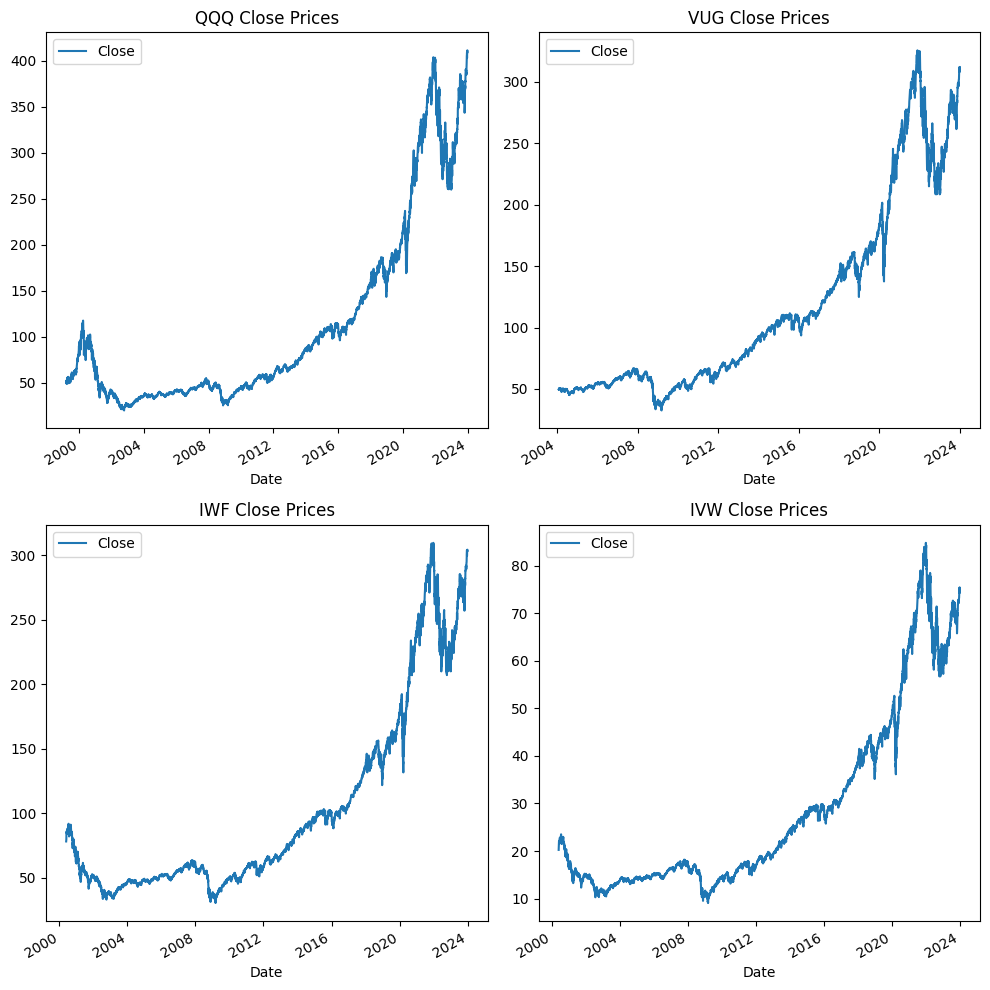

In [4]:
# Plot 4 graphs; define as y functions 
# Initialise the subplot using number of rows and columns (in this case a 4x4 subplot)
figure, axis = plt.subplots(2, 2, figsize=(10,10)) 
qqq.plot.line(y="Close", use_index=True, ax=axis[0,0]).title.set_text('QQQ Close Prices')
vug.plot.line(y="Close", use_index=True, ax=axis[0,1]).title.set_text('VUG Close Prices')
iwf.plot.line(y="Close", use_index=True, ax=axis[1,0]).title.set_text('IWF Close Prices')
ivw.plot.line(y="Close", use_index=True, ax=axis[1,1]).title.set_text('IVW Close Prices')

figure.tight_layout();

In [5]:
# Verify that dataframes look accurate
qqq
#vug
#iwf
#ivw

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
1999-03-10,51.125000,51.156250,50.281250,51.062500,43.604988,5232000
1999-03-11,51.437500,51.734375,50.312500,51.312500,43.818470,9688600
1999-03-12,51.125000,51.156250,49.656250,50.062500,42.751011,8743600
1999-03-15,50.437500,51.562500,49.906250,51.500000,43.978584,6369000
1999-03-16,51.718750,52.156250,51.156250,51.937500,44.352196,4905800
...,...,...,...,...,...,...
2023-12-22,409.000000,409.970001,406.480011,408.380005,408.165314,34292400
2023-12-26,409.250000,411.559998,409.149994,410.880005,410.664001,22722500
2023-12-27,410.950012,411.790009,410.079987,411.500000,411.500000,31980500


# Step 2 - Machine Learning (M.L.) Target

Our target is the following - will the index fund price go up or down? we are not looking for an absolute or specific future price for a particular date (as that is almost impossible to predict, what we are looking for is directionality (ideally we want prices to go up unless you are buying shares for a fund or stock) or a statistic that points out the odds of prices increasing 'tomorrow'.

In [6]:
# For 'next day' prediction we need to create a column where we shift forward 1 day of close prices 
# By shifting 1 row forward - the last will be N/A as it has nothing to get compared with.
qqq["Tomorrow"] = qqq["Close"].shift(-1)
vug["Tomorrow"] = vug["Close"].shift(-1)
iwf["Tomorrow"] = iwf["Close"].shift(-1)
ivw["Tomorrow"] = ivw["Close"].shift(-1)

In [7]:
# Display the dataframe with new column 'Tomorrow'
qqq
#vug
#iwf
#ivw

,Open,High,Low,Close,Adj Close,Volume,Tomorrow
Date,,,,,,,
1999-03-10,51.125000,51.156250,50.281250,51.062500,43.604988,5232000,51.312500
1999-03-11,51.437500,51.734375,50.312500,51.312500,43.818470,9688600,50.062500
1999-03-12,51.125000,51.156250,49.656250,50.062500,42.751011,8743600,51.500000
1999-03-15,50.437500,51.562500,49.906250,51.500000,43.978584,6369000,51.937500
1999-03-16,51.718750,52.156250,51.156250,51.937500,44.352196,4905800,51.562500
...,...,...,...,...,...,...,...
2023-12-22,409.000000,409.970001,406.480011,408.380005,408.165314,34292400,410.880005
2023-12-26,409.250000,411.559998,409.149994,410.880005,410.664001,22722500,411.500000
2023-12-27,410.950012,411.790009,410.079987,411.500000,411.500000,31980500,411.299988


In [8]:
# We now create a Target column with boolean output
# Outputs are 1 for 'True - prices increased the day after' & 0 for 'False - prices decreased the day after'
qqq["Target"] = (qqq["Tomorrow"] > qqq["Close"]).astype(int)
vug["Target"] = (vug["Tomorrow"] > vug["Close"]).astype(int)
iwf["Target"] = (iwf["Tomorrow"] > iwf["Close"]).astype(int)
ivw["Target"] = (ivw["Tomorrow"] > ivw["Close"]).astype(int)

### New columns 'Target' & 'Tomorrow' should display

In [9]:
# Display the dataframe with new column 'Target'
qqq
#vug
#iwf
#ivw

,Open,High,Low,Close,Adj Close,Volume,Tomorrow,Target
Date,,,,,,,,
1999-03-10,51.125000,51.156250,50.281250,51.062500,43.604988,5232000,51.312500,1
1999-03-11,51.437500,51.734375,50.312500,51.312500,43.818470,9688600,50.062500,0
1999-03-12,51.125000,51.156250,49.656250,50.062500,42.751011,8743600,51.500000,1
1999-03-15,50.437500,51.562500,49.906250,51.500000,43.978584,6369000,51.937500,1
1999-03-16,51.718750,52.156250,51.156250,51.937500,44.352196,4905800,51.562500,0
...,...,...,...,...,...,...,...,...
2023-12-22,409.000000,409.970001,406.480011,408.380005,408.165314,34292400,410.880005,1
2023-12-26,409.250000,411.559998,409.149994,410.880005,410.664001,22722500,411.500000,1
2023-12-27,410.950012,411.790009,410.079987,411.500000,411.500000,31980500,411.299988,0


# Step 3 - Train initial model based on a Random Forest Classifier Algorithm

The random forest classifier is a M.L. algorithm that trains multiple decision trees with randomized parameters, and averages results from those decision trees; therefore, random forests are resistant to overfitting (term that refers to the case when a model gives a high accurate prediction for training data but not new data real world information). Note that the open price column is not linearly correlated with the target column (meaning that if open price is higher, that doesn't mean the target price will be higher).

Notice these dataframes we are training are time series data (prices that change with respect to time). The training set consists of all of the rows except the last 100. Last 100 rows go into the testing set, so that the model learns from the past without knowing anything about the future, otherwise accuracy will be high on the model but inefficient in the real world as it would 'already know about the future'.

In [10]:
# Apply model variable to begin process
# 'n estimators' is the number of individual decision trees we want to train, the higher the n, the better the accuracy (up to a limit)
# 'min sample split' reduces overfitting
# 'random state' seed of '1' allows for running the same model multiple times, and that random numbers that are generated will be in a predictable sequence

qqq_model_1 = RandomForestClassifier(n_estimators = 75, min_samples_split = 75, random_state = 1)
vug_model_1 = RandomForestClassifier(n_estimators = 75, min_samples_split = 75, random_state = 1)
iwf_model_1 = RandomForestClassifier(n_estimators = 75, min_samples_split = 75, random_state = 1)
ivw_model_1 = RandomForestClassifier(n_estimators = 75, min_samples_split = 75, random_state = 1)

In [11]:
def ran_basic_model(model, dataframe):
    train = dataframe.iloc[:-100] # We want to train all rows except for last 100
    test = dataframe.iloc[-100:] # We want to test only last 100 rows
    predictors = ["Close", "Volume", "Open", "High", "Low"] # We use absolute numerical data from original cols.
    model.fit(train[predictors], train["Target"]) # Training phase of predictors & boolean based Target column
    
    preds = model.predict(test[predictors]) # Run prediction on testing data - to see if training went well
    preds = pd.Series(preds, index=test.index) # Predictions are stored in a numpy array - turn to Pandas Series
    score = precision_score(test["Target"], preds)
    neg_score = 1 - score
    combined = pd.concat([test["Target"], preds], axis=1)
    combined.plot()
    msg1 = "The probability of price increment for this fund for tomorrow is: " + str(score)
    msg2 = "The probability of price decrement for this fund for tomorrow is: " + str(neg_score)
    print(msg1)
    print(msg2)

### Orange line is the prediction for the last 100 days based off training data for QQQ (24 years & 9 months worth of data points), VUG (19 years & 11 months worth of data points), IWF (23 years & 7 months worth of data points), & IVW (23 years & 7 months worth of data points).

The probability of price increment for this fund for tomorrow is: 0.6129032258064516
The probability of price decrement for this fund for tomorrow is: 0.3870967741935484


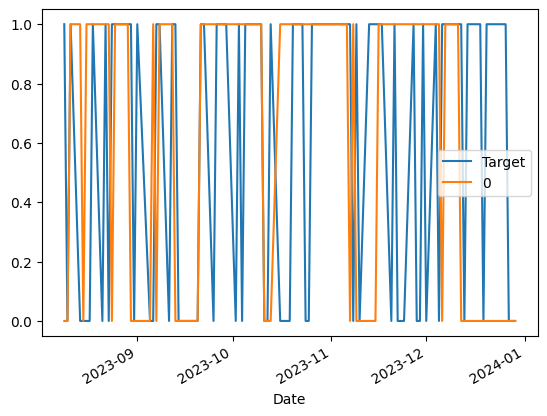

In [12]:
qqq_predictions_1 = ran_basic_model(qqq_model_1, qqq)

The probability of price increment for this fund for tomorrow is: 0.618421052631579
The probability of price decrement for this fund for tomorrow is: 0.381578947368421


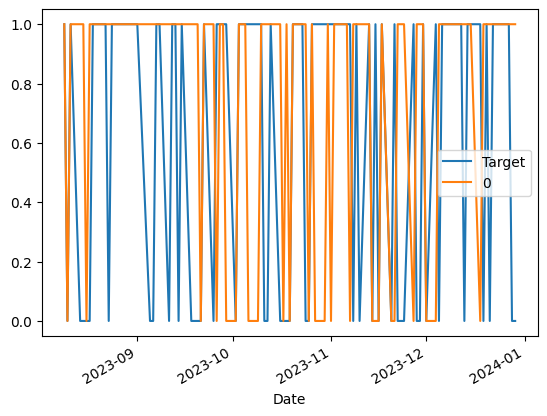

In [13]:
vug_predictions_1 = ran_basic_model(vug_model_1, vug)

The probability of price increment for this fund for tomorrow is: 0.5797101449275363
The probability of price decrement for this fund for tomorrow is: 0.42028985507246375


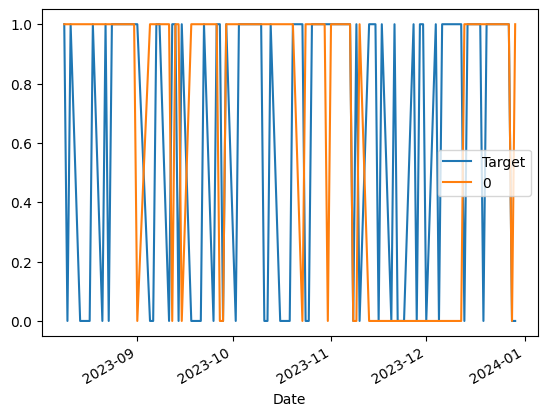

In [14]:
iwf_predictions_1 = ran_basic_model(iwf_model_1, iwf)

The probability of price increment for this fund for tomorrow is: 0.546875
The probability of price decrement for this fund for tomorrow is: 0.453125


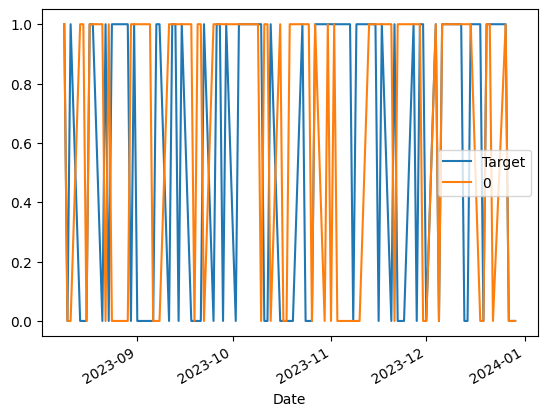

In [15]:
ivw_predictions_1 = ran_basic_model(ivw_model_1, ivw)

# Step 4 - Building a backtest system

The goal is to compare the previous model with the backtest system. We first need to create a predictions function and then a backtest function that for every 10-year period, we'll train 1 year, then the next one, and so forth. Note that every trading year has 250 days, therefore 10 years is 2500 days.

In [16]:
# 1st step - create generic prediction function
def predict(train, test, predictors, model):
    model.fit(train[predictors], train["Target"])
    preds = model.predict(test[predictors])
    preds = pd.Series(preds, index=test.index, name="Predictions")
    combined = pd.concat([test["Target"], preds], axis=1)
    return combined

In [17]:
# 2nd step - backtest function uses previous prediction function
def backtest(dataframe, model, predictors, start=2500, step=250):
    all_predictions = [] 
    # list of dataframes, where we loop across our data year by year (except 1st 10 years) 
    # each data frame is the prediction of a single year
    for i in range(start, dataframe.shape[0], step):
        train = dataframe.iloc[0:i].copy() # training set includes all years prior to current
        test = dataframe.iloc[i:(i+step)].copy() #testing set is current year
        predictions = predict(train, test, predictors, model)
        all_predictions.append(predictions)
    return pd.concat(all_predictions)

# Step 5 - See results from backtest system (2nd round of predictions)

In [18]:
# Set predictors variable - array
predictors = ["Close", "Volume", "Open", "High", "Low"]

In [19]:
# Call backtest function for QQQ
qqq_predictions_2 = backtest(qqq, qqq_model_1, predictors)

In [20]:
# Call backtest function for VUG
vug_predictions_2 = backtest(vug, vug_model_1, predictors)

In [21]:
# Call backtest function for IWF
iwf_predictions_2 = backtest(iwf, iwf_model_1, predictors)

In [42]:
# Call backtest function for IVW
ivw_predictions_2 = backtest(ivw, ivw_model_1, predictors)

### '0' represents prediction when the prices goes down, '1' when the prices goes up

In [43]:
# We are counting QQQ prediction values
qqq_predictions_2["Predictions"].value_counts()

1    2062
0    1682
Name: Predictions, dtype: int64

In [44]:
# We are counting VUG prediction values
vug_predictions_2["Predictions"].value_counts()

0    1431
1    1083
Name: Predictions, dtype: int64

In [45]:
# We are counting IWF prediction values
iwf_predictions_2["Predictions"].value_counts()

0    2362
1    1074
Name: Predictions, dtype: int64

In [46]:
# We are counting IVW prediction values
ivw_predictions_2["Predictions"].value_counts()

0.0    2204
1.0     232
Name: Predictions, dtype: int64

### This percentage means we were x% accurate out of the entire training set. So when we say the fund's value goes 'up', it went up x% of the time

In [47]:
# QQQ percentage
precision_score(qqq_predictions_2["Target"], qqq_predictions_2["Predictions"])

0.5543161978661494

In [48]:
# VUG percentage
precision_score(vug_predictions_2["Target"], vug_predictions_2["Predictions"])

0.5383194829178208

In [49]:
# IWF percentage
precision_score(iwf_predictions_2["Target"], iwf_predictions_2["Predictions"])

0.5344506517690876

In [50]:
# IVW percentage
precision_score(ivw_predictions_2["Target"], ivw_predictions_2["Predictions"])

0.5775862068965517

### Is the previous result good? The benchmark is based on how many times we predicted it would go up divided by total number of rows

In [51]:
# Benchmark for QQQ
qqq_predictions_2["Target"].value_counts() / qqq_predictions_2.shape[0]

1    0.555556
0    0.444444
Name: Target, dtype: float64

In [52]:
# Benchmark for VUG
vug_predictions_2["Target"].value_counts() / vug_predictions_2.shape[0]

1    0.54813
0    0.45187
Name: Target, dtype: float64

In [53]:
# Benchmark for IWF
iwf_predictions_2["Target"].value_counts() / iwf_predictions_2.shape[0]

1    0.549476
0    0.450524
Name: Target, dtype: float64

In [54]:
# Benchmark for IVW
ivw_predictions_2["Target"].value_counts() / ivw_predictions_2.shape[0]

1    0.549261
0    0.450739
Name: Target, dtype: float64

# Step 6 - Insert extra prediction ratio columns

In [55]:
# re-write predict function
def predict(train, test, predictors, model):
    model.fit(train[predictors], train["Target"])
    preds = model.predict_proba(test[predictors])[:,1] #this returns a probability that row will be 0 or 1
    preds[preds >=.6] = 1 #change threshold to 60% - if greater than or equal to .6 then return 1
    preds[preds <.6] = 0 #change threshold to 60% - if less than .6 then return 0
    preds = pd.Series(preds, index=test.index, name="Predictions")
    combined = pd.concat([test["Target"], preds], axis=1)
    return combined

In [56]:
# Add ratio columns to dataframes or datasets
# 'horizons' refer to the last 4 yrs, last year, last 3 month, last 5 days, last 2 days
horizons = [2, 5, 60, 250, 1000] 
qqq_new_predictors = []
vug_new_predictors = []
iwf_new_predictors = []
ivw_new_predictors = []

qqq_model_init = RandomForestClassifier(n_estimators=150, min_samples_split=38, random_state=1)
vug_model_init = RandomForestClassifier(n_estimators=150, min_samples_split=38, random_state=1)
iwf_model_init = RandomForestClassifier(n_estimators=150, min_samples_split=38, random_state=1)
ivw_model_init = RandomForestClassifier(n_estimators=150, min_samples_split=38, random_state=1)

for horizon in horizons:
    qqq_rolling_averages = qqq.rolling(horizon).mean()
    vug_rolling_averages = vug.rolling(horizon).mean()
    iwf_rolling_averages = iwf.rolling(horizon).mean()
    ivw_rolling_averages = ivw.rolling(horizon).mean()

    ratio_column = f"Close_Ratio_{horizon}"
    qqq[ratio_column] = qqq["Close"] / qqq_rolling_averages["Close"]
    vug[ratio_column] = vug["Close"] / vug_rolling_averages["Close"]
    iwf[ratio_column] = iwf["Close"] / iwf_rolling_averages["Close"]
    ivw[ratio_column] = ivw["Close"] / ivw_rolling_averages["Close"]

    trend_column = f"Trend_{horizon}"
    qqq[trend_column] = qqq.shift(1).rolling(horizon).sum()["Target"]
    vug[trend_column] = vug.shift(1).rolling(horizon).sum()["Target"]
    iwf[trend_column] = iwf.shift(1).rolling(horizon).sum()["Target"]
    ivw[trend_column] = ivw.shift(1).rolling(horizon).sum()["Target"]

    qqq_new_predictors += [ratio_column, trend_column]
    vug_new_predictors += [ratio_column, trend_column]
    iwf_new_predictors += [ratio_column, trend_column]
    ivw_new_predictors += [ratio_column, trend_column]

/var/folders/4k/gqcmmjbx2w55jxw4q_lcpc5r0000gn/T/ipykernel_3164/2088652557.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  qqq[ratio_column] = qqq["Close"] / qqq_rolling_averages["Close"]
/var/folders/4k/gqcmmjbx2w55jxw4q_lcpc5r0000gn/T/ipykernel_3164/2088652557.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  vug[ratio_column] = vug["Close"] / vug_rolling_averages["Close"]
/var/folders/4k/gqcmmjbx2w55jxw4q_lcpc5r0000gn/T/ipykernel_3164/2088652557.py:23: SettingWithCopyWarning: 
A value is trying t

In [57]:
qqq = qqq.dropna(subset = qqq.columns[qqq.columns != "Tomorrow"])
vug = vug.dropna(subset = vug.columns[vug.columns != "Tomorrow"])
iwf = iwf.dropna(subset = iwf.columns[iwf.columns != "Tomorrow"])
ivw = ivw.dropna(subset = ivw.columns[ivw.columns != "Tomorrow"])

In [58]:
# Verify new dataframes have no errors
qqq
#vug
#iwf
#ivw

,Open,High,Low,Close,Adj Close,Volume,Tomorrow,Target,Close_Ratio_2,Trend_2,Close_Ratio_5,Trend_5,Close_Ratio_60,Trend_60,Close_Ratio_250,Trend_250,Close_Ratio_1000,Trend_1000
Date,,,,,,,,,,,,,,,,,,
2007-02-22,45.360001,45.549999,45.070000,45.419998,39.428822,116344400,45.259998,0,1.002538,2.0,1.008303,4.0,1.030415,32.0,1.105952,137.0,1.221115,542.0
2007-02-23,45.419998,45.459999,45.060001,45.259998,39.289909,113467100,45.040001,0,0.998236,1.0,1.002969,3.0,1.026548,32.0,1.101627,136.0,1.216136,541.0
2007-02-26,45.480000,45.500000,44.759998,45.040001,39.098927,101623700,43.189999,0,0.997564,0.0,0.996637,3.0,1.021018,32.0,1.095918,135.0,1.209557,541.0
2007-02-27,44.369999,44.480000,43.060001,43.189999,37.492966,317813200,43.330002,1,0.979032,0.0,0.963632,2.0,0.979295,31.0,1.050690,135.0,1.159294,540.0
2007-02-28,43.150002,43.759998,42.930000,43.330002,37.614491,214978700,43.130001,0,1.001618,1.0,0.974847,2.0,0.982744,31.0,1.053925,135.0,1.162449,541.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-12-22,409.000000,409.970001,406.480011,408.380005,408.165314,34292400,410.880005,1,1.000747,2.0,1.003159,4.0,1.082730,39.0,1.189133,140.0,1.297586,550.0
2023-12-26,409.250000,411.559998,409.149994,410.880005,410.664001,22722500,411.500000,1,1.003052,2.0,1.007419,4.0,1.086831,39.0,1.194364,141.0,1.304720,550.0
2023-12-27,410.950012,411.790009,410.079987,411.500000,411.500000,31980500,411.299988,0,1.000754,2.0,1.007783,4.0,1.086066,39.0,1.194064,142.0,1.305876,551.0


# Step 7 - Run predictions (3rd round) after adding ratios & modifying prediction function

In [59]:
# Apply backtest function for QQQ
qqq_predictions_3 = backtest(qqq, qqq_model_init, qqq_new_predictors)

In [60]:
# Apply backtest function for VUG
vug_predictions_3 = backtest(vug, vug_model_init, vug_new_predictors)

In [61]:
# Apply backtest function for IWF
iwf_predictions_3 = backtest(iwf, iwf_model_init, iwf_new_predictors)

In [63]:
# Apply backtest function for IVW
ivw_predictions_3 = backtest(ivw, ivw_model_init, ivw_new_predictors)

### Prediction percentages - QQQ (Precision Score & Benchmark %)

In [64]:
qqq_predictions_3["Predictions"].value_counts()

0.0    1465
1.0     279
Name: Predictions, dtype: int64

In [65]:
# Precision score %
precision_score(qqq_predictions_3["Target"], qqq_predictions_3["Predictions"])

0.5483870967741935

In [66]:
# Benchmark %
qqq_predictions_3["Target"].value_counts() / qqq_predictions_3.shape[0]

1    0.561353
0    0.438647
Name: Target, dtype: float64

### Prediction percentages - VUG (Precision Score & Benchmark %)

In [67]:
vug_predictions_3["Predictions"].value_counts()

0.0    339
1.0    175
Name: Predictions, dtype: int64

In [68]:
# Precision score %
precision_score(vug_predictions_3["Target"], vug_predictions_3["Predictions"])

0.4857142857142857

In [69]:
# Benchmark %
vug_predictions_3["Target"].value_counts() / vug_predictions_3.shape[0]

1    0.505837
0    0.494163
Name: Target, dtype: float64

### Prediction percentages - IWF (Precision Score & Benchmark %)

In [70]:
iwf_predictions_3["Predictions"].value_counts()

0.0    1223
1.0     213
Name: Predictions, dtype: int64

In [71]:
# Precision score %
precision_score(iwf_predictions_3["Target"], iwf_predictions_3["Predictions"])

0.5305164319248826

In [72]:
# Benchmark %
iwf_predictions_3["Target"].value_counts() / iwf_predictions_3.shape[0]

1    0.551532
0    0.448468
Name: Target, dtype: float64

### Prediction percentages - IVW (Precision Score & Benchmark %)

In [73]:
ivw_predictions_3["Predictions"].value_counts()

0.0    1179
1.0     257
Name: Predictions, dtype: int64

In [74]:
# Precision score %
precision_score(ivw_predictions_3["Target"], ivw_predictions_3["Predictions"])

0.5680933852140078

In [75]:
# Benchmark %
ivw_predictions_3["Target"].value_counts() / ivw_predictions_3.shape[0]

1    0.546657
0    0.453343
Name: Target, dtype: float64

# Step 9 - Results

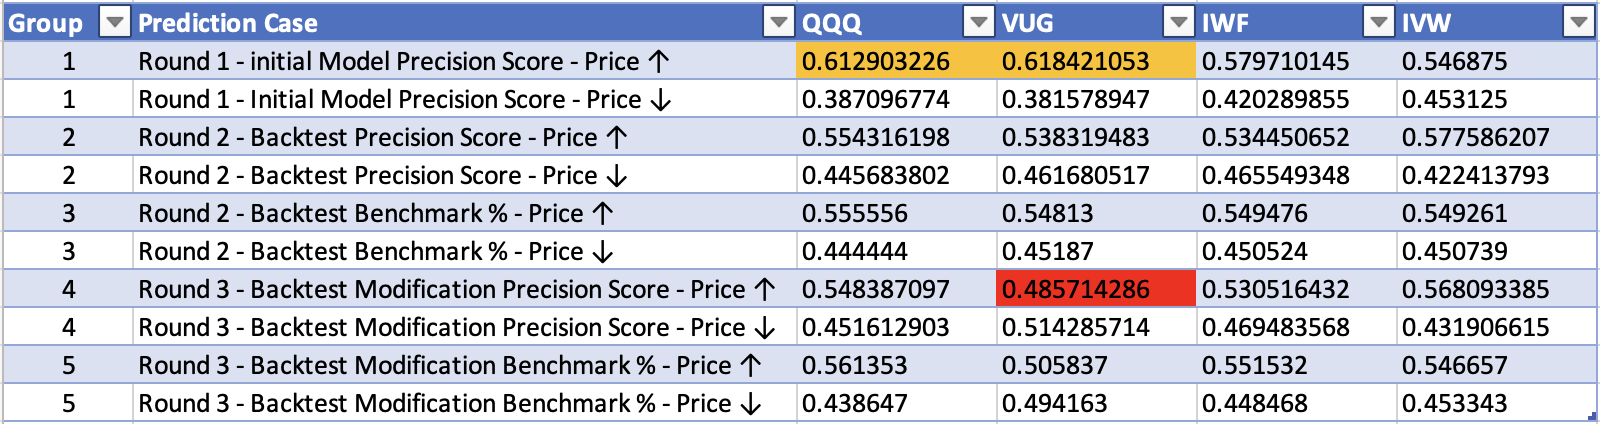

# Step 10 - Conclusion

The random forest decision classifier / machine learning model was trained efficiently as it accurately predicted the odds of share price (from any of the top 4 large growth funds - QQQ, VUG, IWF, IVW) increment in the future or 'tomorrow'. It is reasonable to have a probability ranging between 50% & 60%, as realistically nobody can predict future prices for certain but we are aware (as seen in the financial analysis' Moving Averages graphs - Jupyter Notebooks 1 through 3) that Index Funds tend to increase in value with respect to time despite economic downturns or outlying events (such COVID Pandemic). The highlighted cells (orange & red) represent the percentages that were off - orange being slightly inaccurate & red being incorrect. It is hard to tell the reason why VUG's round 3 precision score was off, as it doesn't lack of historical data. Red was selected as higher inaccuracy is expected on the 1st round but not on the 3rd round after improving the backtest system.